In [ ]:
!pip install Sastrawi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.5 MB/s eta 0:00:00


## 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, TFBertForSequenceClassification
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path ke dataset
dataset_path = "/content/drive/MyDrive/modul/tourist_reviews.csv"

# Load dataset
df = pd.read_csv(dataset_path)

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,datetime,location,text,rating,accessibility,facility,activity
0,47d0cdd937754bd6b860f89b2bab1dbb,2022-05-15 11:58:43,Curug Malela,Akses jalannya waktu itu masih sulit di jangka...,4,negative,neutral,neutral
1,4804acd6c05e4f89b098e2ca35019419,2022-08-15 11:58:43,Curug Malela,"Perjalanan yg bnr"" bikin Syahduu ,, dr Tempat ...",5,neutral,neutral,positive
2,3eae265bf32a45eca31765a4145bc030,2022-03-15 11:58:43,Curug Malela,"Minggu 13 februari 2022 ,\n\ngas santai pakai ...",5,positive,negative,positive
3,61037dbdb7b14045be49d4494e95cf05,2022-05-15 11:58:44,Curug Malela,7 mei 2022\nTouring bari mudik\nMntap perjalan...,5,positive,neutral,positive
4,a2c9e817e2b949c6880f971f43a11d2f,2022-08-15 11:58:44,Curug Malela,Perjalanan touring motor dari bekasi melewati ...,5,neutral,neutral,positive


### EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11620 entries, 0 to 11619
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             11620 non-null  object
 1   datetime       11620 non-null  object
 2   location       11620 non-null  object
 3   text           11620 non-null  object
 4   rating         11620 non-null  int64 
 5   accessibility  11620 non-null  object
 6   facility       11620 non-null  object
 7   activity       11620 non-null  object
dtypes: int64(1), object(7)
memory usage: 726.4+ KB


Distribusi Kelas:
rating
5    7636
4    2773
3     831
1     205
2     175
Name: count, dtype: int64


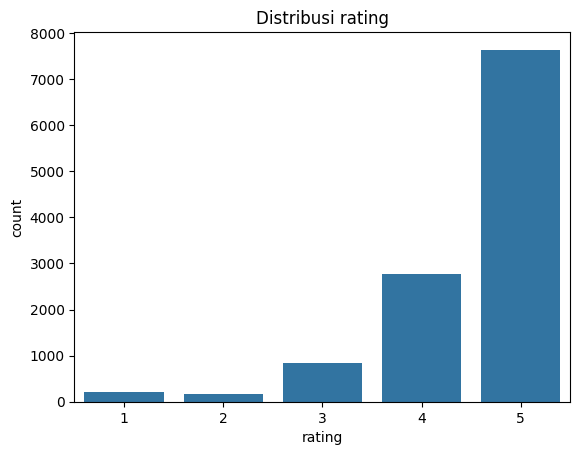

In [ ]:
import seaborn as sns# Distribusi kelas
print("Distribusi Kelas:")
print(df['rating'].value_counts())

# Visualisasi distribusi kelas
sns.countplot(data=df, x='rating')
plt.title('Distribusi rating')
plt.show()


Distribusi Kelas:
activity
positive    7153
neutral     4084
negative     383
Name: count, dtype: int64


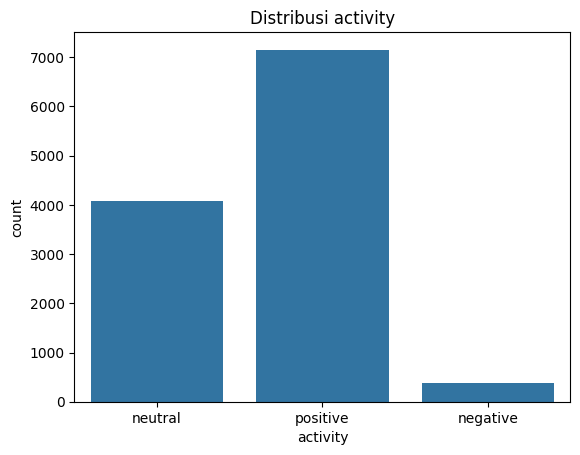

In [ ]:
# Distribusi kelas
print("Distribusi Kelas:")
print(df['activity'].value_counts())

# Visualisasi distribusi kelas
sns.countplot(data=df, x='activity')
plt.title('Distribusi activity')
plt.show()


Distribusi Kelas:
facility
neutral     8105
positive    2318
negative    1197
Name: count, dtype: int64


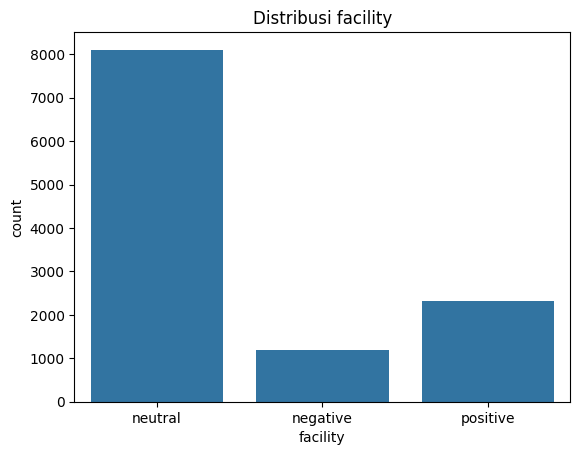

In [ ]:
import seaborn as sns
# Distribusi kelas
print("Distribusi Kelas:")
print(df['facility'].value_counts())

# Visualisasi distribusi kelas
sns.countplot(data=df, x='facility')
plt.title('Distribusi facility')
plt.show()


Distribusi Kelas:
accessibility
neutral     10197
negative      862
positive      561
Name: count, dtype: int64


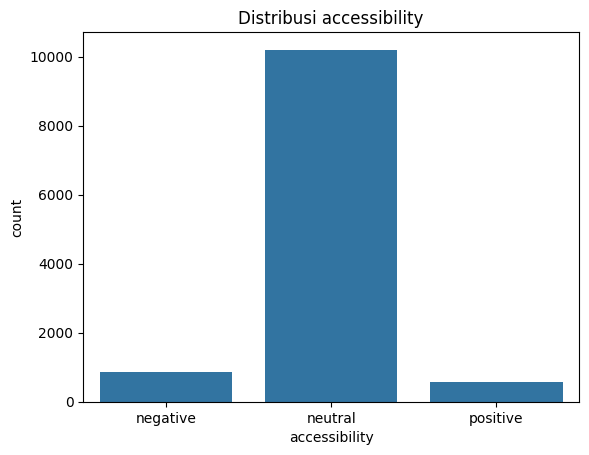

In [ ]:
# Distribusi kelas
print("Distribusi Kelas:")
print(df['accessibility'].value_counts())

# Visualisasi distribusi kelas
sns.countplot(data=df, x='accessibility')
plt.title('Distribusi accessibility')
plt.show()


In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Preprocessing sederhana
def preprocess_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hilangkan URL
    text = re.sub(r'\d+', '', text)  # Hilangkan angka
    text = re.sub(r'[^\w\s]', '', text)  # Hilangkan tanda baca
    text = text.strip()  # Hilangkan spasi ekstra
    return text

# Terapkan preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Tokenisasi
max_words = 5000  # Jumlah kata unik yang akan diproses
max_len = 100  # Panjang maksimal setiap teks

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# One-hot encoding untuk label
y = to_categorical(df['rating'] - 1, num_classes=5)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)


In [ ]:
# Simpan ke file CSV
df.to_csv("preprocessed_data.csv", index=False)
print("File preprocessed_data.csv berhasil disimpan.")

File preprocessed_data.csv berhasil disimpan.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Bangun model LSTM
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')  # 5 kelas
])

# Kompilasi model
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1
)

# Evaluasi model
loss, accuracy = model_lstm.evaluate(X_test, y_test, verbose=1)
print(f"LSTM - Loss: {loss}, Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 74s 292ms/step - accuracy: 0.6530 - loss: 1.0316 - val_accuracy: 0.6640 - val_loss: 0.9350
Epoch 2/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 80s 284ms/step - accuracy: 0.6479 - loss: 0.9720 - val_accuracy: 0.6640 - val_loss: 0.9372
Epoch 3/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 287ms/step - accuracy: 0.6555 - loss: 0.9481 - val_accuracy: 0.6640 - val_loss: 0.9343
Epoch 4/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 81s 283ms/step - accuracy: 0.6578 - loss: 0.9453 - val_accuracy: 0.6640 - val_loss: 0.9345
Epoch 5/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 66s 284ms/step - accuracy: 0.6613 - loss: 0.9457 - val_accuracy: 0.6640 - val_loss: 0.9328
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6577 - loss: 0.9506
LSTM - Loss: 0.9478446841239929, Accuracy: 0.6523236036300659


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

# Bangun model GRU
model_gru = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')  # 5 kelas
])

# Kompilasi model
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Latih model
history_gru = model_gru.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1
)

# Evaluasi model
loss, accuracy = model_gru.evaluate(X_test, y_test, verbose=1)
print(f"GRU - Loss: {loss}, Accuracy: {accuracy}")


Epoch 1/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 78s 305ms/step - accuracy: 0.6462 - loss: 1.0496 - val_accuracy: 0.6640 - val_loss: 0.9603
Epoch 2/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 73s 268ms/step - accuracy: 0.6709 - loss: 0.9309 - val_accuracy: 0.6640 - val_loss: 0.9354
Epoch 3/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - accuracy: 0.6653 - loss: 0.9505 - val_accuracy: 0.6640 - val_loss: 0.9381
Epoch 4/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 62s 268ms/step - accuracy: 0.6629 - loss: 0.9384 - val_accuracy: 0.6640 - val_loss: 0.9371
Epoch 5/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 84s 278ms/step - accuracy: 0.6642 - loss: 0.9412 - val_accuracy: 0.6634 - val_loss: 0.9383
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.6579 - loss: 0.9529
GRU - Loss: 0.9501469731330872, Accuracy: 0.6523236036300659


In [ ]:
from sklearn.metrics import classification_report

# Prediksi LSTM
y_pred_lstm = model_lstm.predict(X_test)
y_pred_classes_lstm = y_pred_lstm.argmax(axis=1) + 1  # Tambahkan 1 agar sesuai dengan kelas 1-5
y_test_classes = y_test.argmax(axis=1) + 1

print("Classification Report LSTM:")
print(classification_report(y_test_classes, y_pred_classes_lstm, target_names=['1', '2', '3', '4', '5']))

# Prediksi GRU
y_pred_gru = model_gru.predict(X_test)
y_pred_classes_gru = y_pred_gru.argmax(axis=1) + 1
y_test_classes = y_test.argmax(axis=1) + 1

print("Classification Report GRU:")
print(classification_report(y_test_classes, y_pred_classes_gru, target_names=['1', '2', '3', '4', '5']))


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step
Classification Report LSTM:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00       176
           4       0.00      0.00      0.00       559
           5       0.65      1.00      0.79      1516

    accuracy                           0.65      2324
   macro avg       0.13      0.20      0.16      2324
weighted avg       0.43      0.65      0.52      2324



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step
Classification Report GRU:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        35
           3       0.00      0.00      0.00       176
           4       0.50      0.00      0.00       559
           5       0.65      1.00      0.79      1516

    accuracy                           0.65      2324
   macro avg       0.23      0.20      0.16      2324
weighted avg       0.55      0.65      0.52      2324



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model_lstm.save("uap.h5")

In [ ]:
model_gru.save("gru.h5")

In [ ]:
import joblib

# Simpan tokenizer ke file
joblib.dump(tokenizer, "tokenizer.joblib")
print("Tokenizer berhasil disimpan.")


Tokenizer berhasil disimpan.
